In [88]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
import transformers
from tqdm import tqdm
from transformers import (
    AutoModelForTokenClassification,
    AutoTokenizer,
    AdamW,
    get_linear_schedule_with_warmup
)
import os
import time
import csv

In [89]:
dataset = pd.read_csv("items_sentences_from_web_2_1.csv")
dataset

,sentence_id,word,label
0,1,Nous,O
1,1,Contacter,O
2,1,La,O
3,1,Vie,O
4,1,éco,O
...,...,...,...
71188,1261,un,O
71189,1261,conseiller,O
71190,1261,appelez,O
71191,1261,le,O


In [90]:
dataset["label"].value_counts()

label
O        69700
PHONE     1493
Name: count, dtype: int64

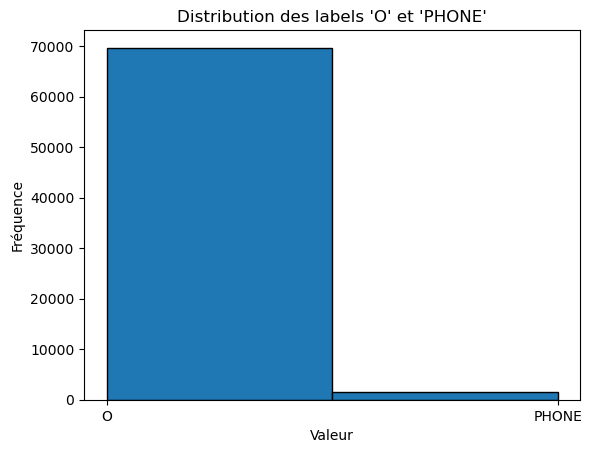

In [91]:
plt.hist(dataset['label'], bins=2, edgecolor='black')

plt.title("Distribution des labels 'O' et 'PHONE'")
plt.xlabel('Valeur')
plt.ylabel('Fréquence')

plt.show()

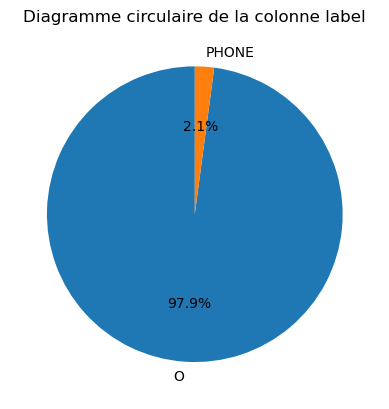

In [92]:
# Compter les occurrences de chaque valeur
value_counts = dataset['label'].value_counts()

# Créer le diagramme circulaire
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90)

plt.title('Diagramme circulaire de la colonne label')
plt.show()

In [93]:
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["word"].values.tolist(), s["label"].values.tolist())]
        self.grouped = self.dataset.groupby("sentence_id").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

getter = SentenceGetter(dataset)

sentences = [' '.join([str(s[0]) for s in sent]) for sent in getter.sentences]
labels = [[s[1] for s in sent] for sent in getter.sentences]


tags_vals = list(set(dataset["label"].values))
tag2idx = {'O': 0, 'PHONE': 1}
labels = [[tag2idx.get(l) for l in lab] for lab in labels]

In [94]:
tag2idx

{'O': 0, 'PHONE': 1}

In [95]:
len(sentences)

1261

In [96]:
sentences[:1]

['Nous Contacter La Vie éco Accueil Au Royaume Evénement Scans Pouvoirs Partis Territoires Sécurité Argent Epargne Taux Banques Budget Public Affaires Echanges Secteurs Niches Investissements Entreprises Carrière Hors Cadre Agriculture Influences Société Réseaux Culture Tentation Auto Climat Médias Idées Edito Chronique Tribune Bouliste Archives Vidéos SUIVEZ NOUS La Vie éco S abonner Se connecter Accueil Au Royaume Evénement Scans Pouvoirs Partis Territoires Sécurité Argent Epargne Taux Banques Budget Public Affaires Echanges Secteurs Niches Investissements Entreprises Carrière Hors Cadre Agriculture Influences Société Réseaux Culture Tentation Auto Climat Médias Idées Edito Chronique Tribune Bouliste Archives Vidéos Nous Contacter Tel (0522)450555/71/72 LG Fax (0522)449421/304542 Adresse 5, Bd Abdellah Ben Yacine Casablanca –20300 À propos de La Vie éco Nous Contacter Abonnement Kit Média Conditions générales de vente La Vie éco 2024. Tous droits réservés Conception et développement 

In [97]:
lens = [len(s) for s in sentences]
lens[:5]

[1015, 1727, 828, 1221, 2013]

In [98]:
max_len = max(lens)
max_len

3601

In [99]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
print(tokenizer.model_max_length)

/opt/conda/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


512


In [100]:
sentence_exemple = sentences[0]

In [101]:
inputs = tokenizer(
            sentence_exemple,
            # add_special_tokens=False,
            padding='max_length',
            max_length=10,
            pad_to_max_length=True,
            return_token_type_ids=False,
            # truncation=True
        )
# print(inputs)
print(inputs.tokens())
print("length : ",len(inputs.tokens()))

['[CLS]', 'No', '##us', 'Contact', '##er', 'La', 'V', '##ie', 'é', '##co', 'A', '##cc', '##ue', '##il', 'Au', 'Roy', '##au', '##me', 'E', '##v', '##én', '##ement', 'Sc', '##ans', 'Po', '##u', '##vo', '##irs', 'Part', '##is', 'Te', '##rri', '##toire', '##s', 'S', '##é', '##cu', '##rit', '##é', 'A', '##rgent', 'E', '##par', '##gne', 'Tau', '##x', 'Ban', '##ques', 'Budget', 'Public', 'Affair', '##es', 'E', '##chang', '##es', 'Se', '##ct', '##eur', '##s', 'Ni', '##ches', 'In', '##ves', '##tis', '##se', '##ments', 'En', '##tre', '##prise', '##s', 'Carr', '##ière', 'Ho', '##rs', 'C', '##ad', '##re', 'Agriculture', 'In', '##f', '##lue', '##nces', 'Société', 'R', '##és', '##eau', '##x', 'Culture', 'Ten', '##tation', 'Auto', 'C', '##lim', '##at', 'M', '##é', '##dia', '##s', 'I', '##d', '##ées', 'Edit', '##o', 'Ch', '##ron', '##ique', 'Tribune', 'Bo', '##uli', '##ste', 'Archives', 'V', '##id', '##é', '##os', 'S', '##UI', '##VE', '##Z', 'NO', '##US', 'La', 'V', '##ie', 'é', '##co', 'S', 'a', '##b

In [102]:
inputs = tokenizer(
            sentence_exemple,
            # add_special_tokens=False,
            padding='max_length',
            max_length=10,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
print(inputs)
print(inputs.tokens())
print("length : ",len(inputs.tokens()))

{'input_ids': [101, 1302, 1361, 24367, 1200, 2001, 159, 1663, 255, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
['[CLS]', 'No', '##us', 'Contact', '##er', 'La', 'V', '##ie', 'é', '[SEP]']
length :  10


In [103]:
def calc_len_tokens(sentence):
    inputs = tokenizer(
            sentence,
            # add_special_tokens=False,
            padding='max_length',
            max_length=10,
            pad_to_max_length=True,
            return_token_type_ids=False,
            # truncation=True
        )

    return len(inputs.tokens())

In [104]:
max_len_tokens = []
for sentence in sentences:
    max_len_tokens.append(calc_len_tokens(sentence))

In [105]:
max_len = max(max_len_tokens)
max_len

1784

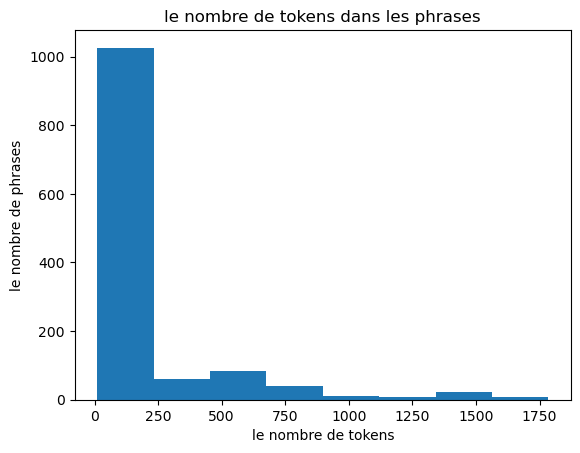

In [106]:
import matplotlib.pyplot as plt
plt.hist(max_len_tokens, bins=8)
plt.title('le nombre de tokens dans les phrases')
plt.xlabel('le nombre de tokens')
plt.ylabel('le nombre de phrases')
plt.show()

In [107]:
MAX_LEN = 1500
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 8
EPOCHS = 100
LEARNING_RATE = 2e-05

In [108]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [109]:
class CustomDataset(Dataset):
    def __init__(self, tokenizer, sentences, labels, max_len):
        self.len = len(sentences)
        self.sentences = sentences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        sentence = str(self.sentences[index])
        label = self.labels[index]
        
        inputs = self.tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            padding="max_length",
            return_tensors="pt"
        )
        
        ###
        inputs = {key: value.squeeze(0) for key, value in inputs.items()}
        ###
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        
        tokens = self.tokenizer.convert_ids_to_tokens(ids)
        label = self.align_labels(tokens, sentence, label)
        
        label.extend([-100]*self.max_len)
        label.insert(0, -100)
        label=label[:self.max_len]

        ###
        label = torch.tensor(label, dtype=torch.long)
        ###
        
        return {
            'input_ids': ids,
            'attention_mask': mask,
            'labels': label
        }
   
    def __len__(self):
        return self.len
    
    def align_labels(self,tokens, sentence, labels):
        B_PHONE_LABEL = 1
        I_PHONE_LABEL = 2
        words = sentence.split(" ")
        index=1
        liste = []
        new_labels = []
        for i, word in enumerate(words):
            len_w = len(word)
            sub_word = ""
            for j in range(index,len(tokens)): 
                token = tokens[j]
                if len(sub_word) > 0 and labels[i]==B_PHONE_LABEL:
                    liste.append((token , I_PHONE_LABEL))
                    new_labels.append(I_PHONE_LABEL)
                else:
                    liste.append((token , labels[i]))
                    new_labels.append(labels[i])
                if token.startswith("##"):
                    token = token.replace("##", "", 1)
                sub_word += token
                if len(sub_word) == len_w :
                    index = j+1
                    break
        return new_labels
        
    def get_data_loader(self, batch_size: int = 8, shuffle: bool = True, num_workers: int = 0) -> DataLoader:
        """Renvoie un DataLoader pour le dataset. //// Charger des données en lots (batches) """
        return DataLoader(self, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)


In [110]:
training_set = CustomDataset(tokenizer, sentences, labels, 30)
inputs = training_set.__getitem__(1190)
input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]
labels_ = inputs["labels"]
tokens = training_set.tokenizer.convert_ids_to_tokens(input_ids)

print(f"Origin Text : {sentences[1190]}")
print(f"Tokens : {tokens}")
print(f"*"*150)
print(f"Torch Tensor")
print(f"*"*150)
print(f"Input_ids : {input_ids}")
print(f"Attention_mask : {attention_mask}")
print(f"Labels : {labels_}")

Origin Text : Pour des questions contactez le (+212)567890123
Tokens : ['[CLS]', 'Po', '##ur', 'des', 'questions', 'contact', '##ez', 'le', '(', '+', '212', ')', '56', '##7', '##8', '##90', '##12', '##3', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
******************************************************************************************************************************************************
Torch Tensor
******************************************************************************************************************************************************
Input_ids : tensor([  101, 18959,  2149,  3532,  3243,  3232,  6409,  5837,   113,   116,
        19538,   114,  4376,  1559,  1604, 21500, 11964,  1495,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])
Attention_mask : tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0])
L

In [111]:
train_percent = 0.98
train_size = int(train_percent*len(sentences))
# train_dataset=df.sample(frac=train_size,random_state=200).reset_index(drop=True)
# test_dataset=df.drop(train_dataset.index).reset_index(drop=True)
train_sentences = sentences[0:train_size]
train_labels = labels[0:train_size]

test_sentences = sentences[train_size:]
test_labels = labels[train_size:]

print("FULL Dataset: {}".format(len(sentences)))
print("TRAIN Dataset: {}".format(len(train_sentences)))
print("Val Dataset: {}".format(len(test_sentences)))

training_set = CustomDataset(tokenizer, train_sentences, train_labels, MAX_LEN)
testing_set = CustomDataset(tokenizer, test_sentences, test_labels, MAX_LEN)

FULL Dataset: 1261
TRAIN Dataset: 1235
Val Dataset: 26


In [112]:
train_loader = training_set.get_data_loader(batch_size=TRAIN_BATCH_SIZE)
val_loader = testing_set.get_data_loader(batch_size=VALID_BATCH_SIZE)

In [27]:
from transformers import AutoConfig, AutoModelForTokenClassification

model_name_or_path = "bert-base-cased"
config = AutoConfig.from_pretrained(model_name_or_path)

# le nombre maximale des tokens
config.max_position_embeddings = MAX_LEN

config.num_labels = 3
config.id2label = {0: "O", 1: "B-PHONE", 2: "I-PHONE"}
config.label2id = {"O": 0, "B-PHONE": 1, "I-PHONE": 2}
# Charger le modèle avec la nouvelle configuration
model = AutoModelForTokenClassification.from_config(config)

/opt/conda/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/opt/conda/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [30]:
model_save_path = f"./models/fine_tuned_ner_model_for_phone_numbers_12_{MAX_LEN}_max_len_webIemData"

In [ ]:
### FINETUNING ###
import numpy as np
import csv
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Configurations de l'entraînement
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)  # Optimiseur basé sur Adam, adapté pour entraîner des modèles de transformer avec un taux d'apprentissage de 3e-5

num_epochs = EPOCHS  # Nombre d'époques
loss_function = torch.nn.CrossEntropyLoss(ignore_index=-100)  # Fonction de perte

#Planificateur de taux d'apprentissage pour ajuster le taux d'apprentissage au fil du temps
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_loader) * num_epochs  # Nombre total de pas d'entraînement
)

csv_filename = f"{model_save_path}_info.csv"
header = ["epoch", "train_loss", "train_accuracy", "val_loss", "val_accuracy", \
          "train_precision", "train_recall", "train_f1", \
          "val_precision", "val_recall", "val_f1"]
is_empty = True

##### added ##############
all_train_predictions = []
all_train_true_labels = []
########################

# Boucle d'entraînement
start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    
    for batch in tqdm(train_loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss  # Obtenir la perte
        loss.backward()  # Calculer le gradient
        optimizer.step()  # Mettre à jour les paramètres
        scheduler.step()  # Mettre à jour le planificateur
        
        total_train_loss += loss.item()  # Ajouter la perte totale

########### added for save other metrics like ############################################################################
        true_labels = batch["labels"].cpu().numpy()  # Labels réels

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits  # Les sorties du modèle
        predicted_labels = torch.argmax(logits, dim=2).cpu().numpy()  # Prédictions du modèle

        # Masque pour ignorer les indices de perte ignorés (-100)
        mask = true_labels != -100

        # Stocke les prédictions et les vrais labels
        all_train_predictions.extend(predicted_labels[mask])
        all_train_true_labels.extend(true_labels[mask])

    # Calcul des métriques
    train_accuracy = accuracy_score(all_train_true_labels, all_train_predictions)
    train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(all_train_true_labels, all_train_predictions, average='weighted')
############################################################################################################################

    # Évaluer le modèle sur l'ensemble de validation
    model.eval()  # Mettre le modèle en mode évaluation
    val_loss = 0.0
    all_val_true_labels = []
    all_val_predictions = []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            val_loss += outputs.loss.item()
########### added for save other metrics like ############################################################################
            true_labels = batch["labels"].cpu().numpy()  # Labels réels
    
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits  # Les sorties du modèle
            predicted_labels = torch.argmax(logits, dim=2).cpu().numpy()  # Prédictions du modèle
    
            # Masque pour ignorer les indices de perte ignorés (-100)
            mask = true_labels != -100
    
            # Stocke les prédictions et les vrais labels
            all_val_predictions.extend(predicted_labels[mask])
            all_val_true_labels.extend(true_labels[mask])
    
        # Calcul des métriques
        val_accuracy = accuracy_score(all_val_true_labels, all_val_predictions)
        val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(all_val_true_labels, all_val_predictions, average='weighted')
############################################################################################################################

    training_details = f"Époque {epoch + 1}/{num_epochs} - Perte d'entraînement : {total_train_loss/len(train_loader)} - Perte de validation : {val_loss/len(val_loader)}"
    print(training_details)

    row_training_details = {"epoch" : epoch+1, \
                            "train_loss" : total_train_loss/len(train_loader), "train_accuracy" : train_accuracy, \
                            "val_loss" : val_loss/len(val_loader), "val_accuracy" : val_accuracy, \
                            "train_precision" : train_precision, "train_recall" : train_recall, "train_f1" : train_f1, \
                            "val_precision" : val_precision, "val_recall" : val_recall, "val_f1" : val_f1}
    
    with open(csv_filename, 'a', newline='', encoding='utf-8-sig') as csvfile:
        csv_writer = csv.DictWriter(csvfile, fieldnames=header)
        if is_empty:
            csv_writer.writeheader()
            is_empty = False
        csv_writer.writerow(row_training_details)

    if (epoch+1) % 10 == 0 :
        end_time = time.time()
        total_fine_tuning_time = end_time - start_time
        
        training_details = f"Fine-tuning terminé! Temps total: {total_fine_tuning_time:.2f} secondes | {total_fine_tuning_time/60:.2f} min | {total_fine_tuning_time/3600:.2f} hours"
        print(training_details)
        
        row_training_details = {"epoch" : training_details, \
                                "train_loss" : "" , "train_accuracy" : "", \
                                "val_loss" : "", "val_accuracy" : "", \
                                "train_precision" : "", "train_recall" : "", "train_f1" : "", \
                                "val_precision" : "", "val_recall" : "", "val_f1" : ""}
        
        # Enregistrer le modèle finetuné
        model.save_pretrained(f"{model_save_path}_{epoch+1}_epochs")
        print(f"Modèle enregistré à {model_save_path}")
        
        with open(csv_filename, 'a', newline='', encoding='utf-8-sig') as csvfile:
            csv_writer = csv.DictWriter(csvfile, fieldnames=header)
            csv_writer.writerow(row_training_details)
    
end_time = time.time()
total_fine_tuning_time = end_time - start_time

training_details = f"Fine-tuning terminé! Temps total: {total_fine_tuning_time:.2f} secondes | {total_fine_tuning_time/60:.2f} min | {total_fine_tuning_time/3600:.2f} hours"
print(training_details)

row_training_details = {"epoch" : training_details, \
                        "train_loss" : "" , "train_accuracy" : "", \
                        "val_loss" : "", "val_accuracy" : "", \
                        "train_precision" : "", "train_recall" : "", "train_f1" : "", \
                        "val_precision" : "", "val_recall" : "", "val_f1" : ""}

# Enregistrer le modèle finetuné
model.save_pretrained(f"{model_save_path}_{epoch+1}_epochs")
print(f"Modèle enregistré à {model_save_path}")

with open(csv_filename, 'a', newline='', encoding='utf-8-sig') as csvfile:
    csv_writer = csv.DictWriter(csvfile, fieldnames=header)
    csv_writer.writerow(row_training_details)

/opt/conda/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  4%|▍         | 6/155 [04:33<1:52:24, 45.27s/it]

In [29]:
### TEST ###
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Charger le modèle enregistré
model_path = "./models/fine_tuned_ner_model_for_phone_numbers_12_1500_max_len_webIemData_50_epochs"
model = AutoModelForTokenClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Test du modèle
model.eval()  # Met le modèle en mode évaluation
all_predictions = []
all_true_labels = []

with torch.no_grad():  # Pas besoin de calculer les gradients en mode évaluation
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        true_labels = batch["labels"].cpu().numpy()  # Labels réels

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits  # Les sorties du modèle
        predicted_labels = torch.argmax(logits, dim=2).cpu().numpy()  # Prédictions du modèle

        # Masque pour ignorer les indices de perte ignorés (-100)
        mask = true_labels != -100

        # Stocke les prédictions et les vrais labels
        all_predictions.extend(predicted_labels[mask])
        all_true_labels.extend(true_labels[mask])

# Calcul des métriques
accuracy = accuracy_score(all_true_labels, all_predictions)
precision, recall, f1, _ = precision_recall_fscore_support(all_true_labels, all_predictions, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

/opt/conda/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Accuracy: 0.9986893840104849
Precision: 0.9986919639632201
Recall: 0.9986893840104849
F1-Score: 0.998688601947862


In [48]:
result = pd.read_csv("./models/fine_tuned_ner_model_for_phone_numbers_12_1500_max_len_webIemData_info.csv")
result[:50]

,epoch,train_loss,train_accuracy,val_loss,val_accuracy,train_precision,train_recall,train_f1,val_precision,val_recall,val_f1
0,1,0.188453,0.970749,0.120691,0.946265,0.966938,0.970749,0.966705,0.959557,0.946265,0.947848
1,2,0.065384,0.976274,0.080616,0.954128,0.974089,0.976274,0.974024,0.954373,0.954128,0.954156
2,3,0.097850,0.977969,0.071662,0.967235,0.976167,0.977969,0.976167,0.969159,0.967235,0.968017
3,4,0.055935,0.979404,0.053655,0.976409,0.977897,0.979404,0.977933,0.982152,0.976409,0.977648
4,5,0.071925,0.980570,0.074309,0.961992,0.979297,0.980570,0.979344,0.962821,0.961992,0.962297
5,6,0.047351,0.981449,0.068813,0.971166,0.980322,0.981449,0.980377,0.976391,0.971166,0.972608
6,7,0.033970,0.982366,0.102170,0.955439,0.981376,0.982366,0.981423,0.958967,0.955439,0.957042
7,8,0.041122,0.983125,0.044930,0.976409,0.982235,0.983125,0.982273,0.980936,0.976409,0.977787
8,9,0.060883,0.983625,0.063496,0.977720,0.982798,0.983625,0.982840,0.982638,0.977720,0.979114
9,10,0.055253,0.984054,0.058968,0.971166,0.983277,0.984054,0.983334,0.970999,0.971166,0.971050


In [51]:
# Trouver l'indice de la dernière ligne contenant au moins un NaN
last_nan_index = result[result.isna().any(axis=1)].index[-1]
result = result[:last_nan_index+1]
result.iloc[last_nan_index,0]

'Fine-tuning terminé! Temps total: 348829.06 secondes | 5813.82 min | 96.90 hours'

In [60]:
cleaned_result = result.dropna()
cleaned_result

,epoch,train_loss,train_accuracy,val_loss,val_accuracy,train_precision,train_recall,train_f1,val_precision,val_recall,val_f1
0,1,0.188453,0.970749,0.120691,0.946265,0.966938,0.970749,0.966705,0.959557,0.946265,0.947848
1,2,0.065384,0.976274,0.080616,0.954128,0.974089,0.976274,0.974024,0.954373,0.954128,0.954156
2,3,0.097850,0.977969,0.071662,0.967235,0.976167,0.977969,0.976167,0.969159,0.967235,0.968017
3,4,0.055935,0.979404,0.053655,0.976409,0.977897,0.979404,0.977933,0.982152,0.976409,0.977648
4,5,0.071925,0.980570,0.074309,0.961992,0.979297,0.980570,0.979344,0.962821,0.961992,0.962297
5,6,0.047351,0.981449,0.068813,0.971166,0.980322,0.981449,0.980377,0.976391,0.971166,0.972608
6,7,0.033970,0.982366,0.102170,0.955439,0.981376,0.982366,0.981423,0.958967,0.955439,0.957042
7,8,0.041122,0.983125,0.044930,0.976409,0.982235,0.983125,0.982273,0.980936,0.976409,0.977787
8,9,0.060883,0.983625,0.063496,0.977720,0.982798,0.983625,0.982840,0.982638,0.977720,0.979114
9,10,0.055253,0.984054,0.058968,0.971166,0.983277,0.984054,0.983334,0.970999,0.971166,0.971050


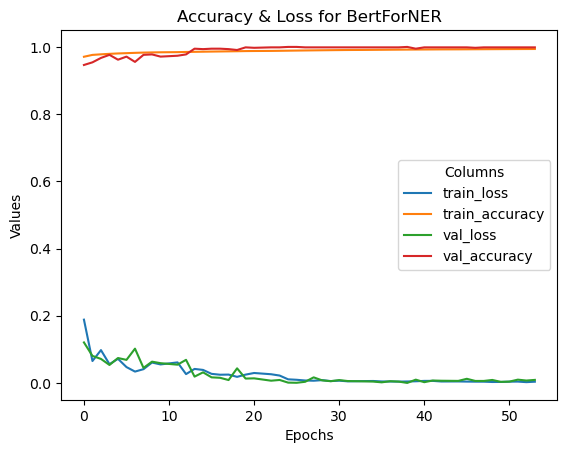

In [87]:
df_loss_accuracy = cleaned_result[["train_loss", "train_accuracy",	"val_loss",	"val_accuracy"]]

# Afficher les 4 premières colonnes dans la même figure
df_loss_accuracy.plot()
plt.title("Accuracy & Loss for BertForNER")
plt.xlabel("Epochs")
plt.ylabel("Values")
plt.legend(title="Columns")
plt.show()

In [73]:
import torch
from transformers import (
    AutoModelForTokenClassification,
    BertTokenizer)

class PhoneModel:
    def __init__(self):
        self.model_path = "./models/fine_tuned_ner_model_for_phone_numbers_12_1500_max_len_webIemData_50_epochs"
        self.model = AutoModelForTokenClassification.from_pretrained(self.model_path)
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
        self.max_len = self.model.config.max_position_embeddings
    def predict(self, sentence):
        # Tokenization de la phrase
        input_data = self.tokenizer.encode_plus(
                    sentence,
                    add_special_tokens=True,
                    # return_token_type_ids=False,
                    truncation=True,
                    max_length= self.max_len,
                    padding="max_length",
                    return_tensors="pt"
                )
        
        # Passer les données au modèle pour obtenir les étiquettes
        with torch.no_grad():
            outputs = self.model(
                input_ids=input_data["input_ids"],
                attention_mask=input_data["attention_mask"]
            )
        
        # Obtenir les prédictions des étiquettes
        predicted_labels = torch.argmax(outputs.logits, dim=2).squeeze().tolist()
        
        # Transformer les indices en étiquettes
        index_to_label = {0: "O", 1: "B-PHONE", 2: "I-PHONE"}
        predicted_labels_named = [index_to_label[label] for label in predicted_labels]
        
        # Extraire les tokens
        tokens = self.tokenizer.convert_ids_to_tokens(input_data["input_ids"].squeeze())
        phone_numbers = self.extract_phones(tokens,predicted_labels_named)
        return phone_numbers
        
    def extract_phones(self, tokens, predicted_labels_named):
        # Reconstituer les entités de type téléphone
        phone_numbers = []
        current_number = []
        
        for token, label in zip(tokens, predicted_labels_named):
            # Fusion des sous-mots sans espace pour maintenir la cohérence des numéros de téléphone
            token = token.replace("#", "")
            token = token.replace("[CLS]", "")
            token = token.replace("[SEP]", "")
            clean_token = token.replace("[PAD]", "")
            if label == "B-PHONE":
                if current_number :
                    phone_numbers.append("".join(current_number))
                    current_number = []
                if len(clean_token) > 0 :
                    current_number.append(clean_token)
            elif label == "I-PHONE":
                if len(clean_token) > 0 :
                    current_number.append(clean_token)
            elif current_number :
                phone_numbers.append("".join(current_number))
                current_number = []
        
        # Ajouter le dernier numéro s'il existe
        if current_number:
            phone_numbers.append("".join(current_number))
        
        return phone_numbers

In [74]:
import time

In [75]:
model = PhoneModel()

In [41]:
for i in range(2):
    print(model.predict(sentences[i+20]),sentences[i+20])

['+2250554113113', '+2252522010110', '+2252522010110', '+2252522010110', '14'] Weblogy Contacts Service Carte +2250554113113 Service Pub +2252522010110 Nous Contacter ACCUEIL QUI SOMMES NOUS Notre entreprise Nos clients Nos Partenaires Nos Bureaux SERVICES Communication digitale Consulting Développement Web et Mobile Service Web Coworking Space PROGRAM MANAGER VISA RÉGIE PUBLICITAIRE Annonceurs Avantages Réseau sites partenaires Serveur de publicité Réseaux sociaux Elaboration des campagnes Suivi des Campagnes Editeurs Avantages Gestion Publicitaire Paiement Créateurs Youtube Rejoignez nous Spécifications Techniques Régie Weblogy Media Weblogy Media Weblogy Media Weblogy Media Weblogy Media prevnext Accueil Qui sommes nous Notre entreprise Nos clients Nos Partenaires Nos Bureaux Services Communication digital Consulting Développement Web et Mobile Service Web Coworking Space Program Manager VISA Régie Publicitaire Avantages Annonceurs Avantages Editeurs Serveur de publicité Réseaux Soc

In [76]:
start = time.time()
test_sentence = " niveau des ministères des AE | Rédaction & Administration 17, Rue Othmane Ben Affane - 20.000 Casablanca, Maroc Tél. : +212.522.48.91.00 Fax. : +212.522.20.30.48 Email : redactions@lematin.ma Publicité 17, Rue Othmane Ben Affane - 20.000 Casablanca, Maroc Tél. : +212.522.48.91.58 Petites annonces 88, Boulevard Mohammed V - 20.000 Casablanca, Maroc"
phones = model.predict(test_sentence)
end = time.time()
print(phones)
print(f"time execution is : {end - start}")

['-20.000', '.', '+212.522.48.91.00', '.', '+212.522.', '.30.48', '.', '-', '.', '.', '+212.522', '48', '91.58', '88', '-', '.']
time execution is : 0.829242467880249


In [77]:
start = time.time()
test_sentence = "Je suis en retard, appelez-moi au 0612345678 et l'autre nemuro c'est 051273195578 dès que possible."
phones = model.predict(test_sentence)
end = time.time()
print(phones)
print(f"time execution is : {end - start}")

['-', '0612345678', '051273195578', '.']
time execution is : 0.7446677684783936


In [78]:
start = time.time()
test_sentence = "Je suis en retard, appelez-moi au 06.12.34.56.78 et sur le fix +051273195578 dès que possible."
phones = model.predict(test_sentence)
end = time.time()
print(phones)
print(f"time execution is : {end - start}")

['-', '06.12.34.56.78', '+', '051273195578', '.']
time execution is : 0.8551599979400635


In [79]:
start = time.time()
test_sentence = "Je suis en retard, appelez-moi au (+212)6.12-34.56.78 et 06.67.89.90.00 dès que possible."
phones = model.predict(test_sentence)
end = time.time()
print(phones)
print(f"time execution is : {end - start}")

['-', '(+212)6.12-34.56.78', '06.67.89.90.00', '.']
time execution is : 0.8606958389282227


In [2]:
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities

In [3]:
server = f"http://192.168.3.32:4444/wd/hub"
options = webdriver.ChromeOptions()
driver = webdriver.Remote(command_executor=server, options=options)

In [4]:
url = "https://lematin.ma/contact"
driver.get(url)

In [5]:
WebDriverWait(driver, 10).until(
EC.presence_of_element_located((By.TAG_NAME, "body"))
)           
print(driver.current_url)
contenu_html = driver.page_source
driver.quit()

https://lematin.ma/contact


In [6]:
def extract_chunks(contenu_html, max_len_chunk = 400, pad = 6):
    soup = BeautifulSoup(contenu_html, 'html.parser')
    text = soup.text
    new_text = ' '.join([n.strip() for n in text.split('\n') if n != ''])
    text_list = new_text.split()
    len_text_list = len(text_list)
    n_chunks= int(len_text_list / max_len_chunk)+1
    
    chunks = []
    for i in range(n_chunks):
        if i == 0:
            start = i*max_len_chunk
            end = min((i+1)*max_len_chunk,len_text_list)
        else:
            start = end - pad
            end = min(((i+1)*max_len_chunk) - pad , len_text_list)
            
        chunk = text_list[start:end]
        chunks.append(' '.join(chunk))
        
        if i == n_chunks-1 and end != len_text_list and len(chunk)==max_len_chunk:
            start = end - pad
            end = len_text_list
            chunk = text_list[start:end]
            chunks.append(' '.join(chunk))
    return chunks

In [7]:
chunks = extract_chunks(contenu_html, max_len_chunk = 300)
chunks[1]

"adoptés | En direct : Le GIPAM présente le programme du Salon Moroccan Automotive Technologies 2024 | Marocains détenus à Myanmar : ouverture d'une enquête judiciaire confiée à la BNPJ | L'Info en Face avec Salma Benaddou | Marocains détenus à Myanmar : L’ambassade du Maroc multiplie les démarches pour aider les victimes | Busway-Tramway de Casablanca : voici les nouveaux prix adoptés | En direct : Le GIPAM présente le programme du Salon Moroccan Automotive Technologies 2024 | Marocains détenus à Myanmar : ouverture d'une enquête judiciaire confiée à la BNPJ | L'Info en Face avec Salma Benaddou | Marocains détenus à Myanmar : L’ambassade du Maroc multiplie les démarches pour aider les victimes | Busway-Tramway de Casablanca : voici les nouveaux prix adoptés | En direct : Le GIPAM présente le programme du Salon Moroccan Automotive Technologies 2024 | Rédaction & Administration 17, Rue Othmane Ben Affane - 20.000 Casablanca, Maroc Tél. : +212.522.48.91.00 Fax. : +212.522.20.30.48 Email 

In [11]:
from transformers import AutoTokenizer

model_checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

inputs = tokenizer(
            chunks[1],
            # add_special_tokens=False,
            padding='max_length',
            max_length=512,
            pad_to_max_length=True,
            return_token_type_ids=False,
            # truncation=True
        )
#print(inputs)
print("length : ",len(inputs.tokens()))
print(inputs.tokens())

length :  694
['[CLS]', 'adopt', '##és', '|', 'En', 'direct', ':', 'Le', 'G', '##IP', '##AM', 'p', '##ré', '##sent', '##e', 'le', 'programme', 'du', 'Salon', 'Moroccan', 'Auto', '##mot', '##ive', 'Technologies', '202', '##4', '|', 'Mar', '##oc', '##ain', '##s', 'd', '##é', '##ten', '##us', 'à', 'Myanmar', ':', 'ou', '##vert', '##ure', 'd', "'", 'une', 'en', '##q', '##u', '##ê', '##te', 'j', '##udi', '##cia', '##ire', 'con', '##fi', '##ée', 'à', 'la', 'B', '##NP', '##J', '|', 'L', "'", 'In', '##fo', 'en', 'Face', 'a', '##ve', '##c', 'Sal', '##ma', 'Ben', '##ad', '##do', '##u', '|', 'Mar', '##oc', '##ain', '##s', 'd', '##é', '##ten', '##us', 'à', 'Myanmar', ':', 'L', '’', 'am', '##bas', '##sad', '##e', 'du', 'Mar', '##oc', 'multi', '##p', '##lie', 'les', 'd', '##é', '##mar', '##ches', 'pour', 'aide', '##r', 'les', 'victim', '##es', '|', 'Bus', '##way', '-', 'T', '##ram', '##way', 'de', 'Casablanca', ':', 'v', '##oi', '##ci', 'les', 'no', '##uveau', '##x', 'p', '##rix', 'adopt', '##és', '

In [12]:
# 0 : 723
# 1 : 856
for ch in chunks:
    print(ch)
    print(f"*"*100)

Contact Le Matin.ma | Adresses et numéros de téléphone des différents départements - Le Matin.ma contact Publicité Sites du Groupe Club Avantages Le Matin Sports Assahraa Le Matin Store Le Matin Annonces Les Imprimeries du Matin Morocco Today Forum Services Horaires de prières Pharmacies de garde Météo Programme TV Cinéma Horaires de train Bourse Connexion Se Connecter Abonnement Archives ePaper Jeudi 16 Mai 2024 S'inscrire à notre Newsletter S'abonner Jeudi 16 Mai 2024 S'inscrire à notre Newsletter S'abonner Jeudi 16 Mai 2024 Newsletter S'abonner se connecter Abonnement Archives ePaper Jeudi 16 Mai 2024 Newsletter S'abonner se connecter Abonnement Archives ePaper Activités royales Nation Économie Monde Société Culture Sports S'inscrire à Notre Newsletter Matin TV Activités Royales Nation Économie Monde Société Culture Régions Emploi Enseignement Sports Automobile Chroniques Nos Spéciaux Horaires de prières Pharmacies de garde Météo Programme TV Cinéma Horaires de train Bourse Podcast 